In [50]:
# Imputers
from fancyimpute import SimpleFill
from fancyimpute import KNN
from fancyimpute import SoftImpute
from fancyimpute import IterativeImputer
from fancyimpute import IterativeSVD
from fancyimpute import MatrixFactorization

# Missing Values
from utils import *

# PreProcessing
from sklearn.preprocessing import MinMaxScaler

# Error Metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Utilities
import pandas as pd
import numpy as np
import math

# Visualizations
from plot_methods import *
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor'] = 'white'

## 1. Preparation

In [3]:
data_path_pairs = [] 
data_path_pairs.append(('Iris' , '../data/iris.csv'))
data_path_pairs.append(('Airfoil Self Noise' , '../data/airfoil_self_noise.csv'))
data_path_pairs.append(('Wine' , '../data/wine.csv'))


In [4]:
imputer_pairs = []
imputer_pairs.append(('SimpleFill' , SimpleFill()))
imputer_pairs.append(('KNN' , KNN(min_value=0, max_value=1, verbose=False)))
imputer_pairs.append(('SoftImpute' , SoftImpute(min_value=0, max_value=1, verbose=False)))
imputer_pairs.append(('IterativeImputer' , IterativeImputer(min_value=0, max_value=1, verbose=False)))
imputer_pairs.append(('IterativeSVD' , IterativeSVD(min_value=0, max_value=1, verbose=False)))
imputer_pairs.append(('MatrixFactorization' , MatrixFactorization(min_value=0, max_value=1, verbose=False)))

In [5]:
mv_type_names = []
mv_type_names.append('mcar')
mv_type_names.append('mar')
mv_type_names.append('mnar')

In [6]:
mv_proportions = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

In [7]:
scaler = MinMaxScaler()
np.random.seed(42)

In [8]:
def GetResultDictionaryForImputation(X_true, X_pred, mask):
    result_dict = {}

    # Get Result values
    pred_values = X_pred[mask]
    true_values = X_true[mask]

    # Append MAE and RMSE
    result_dict['mae'] = (mean_absolute_error(true_values, pred_values))
    result_dict['rmse'] = (math.sqrt(mean_squared_error(true_values, pred_values)))

    return result_dict

## 2. Impute for Missing Value Types

### 2.1 Imputation

In [9]:
results_mv_type = {}

# Iterate data sets
for data_name, data_path in data_path_pairs:

    results_per_dataset = {}

    # Load Data
    data = pd.read_csv(data_path, header=None)

    # Scale Data
    data.columns = data.columns.astype(str)
    X_true = scaler.fit_transform(data)

    for mv_type_name in mv_type_names:
        
        results_per_percentage = {}

        # Get Missing Data Mask
        if mv_type_name == 'mcar':
            mv_mask = MCAR_mask(X_true, 0.2)
        if mv_type_name == 'mar':
            mv_mask = MAR_mask(X_true, 0.2, 0.2)
        if mv_type_name == 'mnar':
            mv_mask = MNAR_mask_logistic(X_true, 0.2)

        # Insert missing values
        X_dropped = X_true.copy()
        X_dropped[mv_mask] = np.nan

        # Iterate through Imputers
        for imputer_name, imputer in imputer_pairs:

            if isinstance(imputer, IterativeSVD):
                # Rank of IterativeSVD imputer must not be less than the x shape of the dataset
                # 10 is the default rank
                imputer.rank = min(10, data.shape[1] - 1)

            # Impute
            X_pred = imputer.fit_transform(X_dropped)
            
            results_per_percentage[imputer_name] = GetResultDictionaryForImputation(X_true, X_pred, mv_mask)
        
        results_per_dataset[mv_type_name] = results_per_percentage
    
    results_mv_type[data_name] = results_per_dataset

c:\Users\brand\miniconda3\envs\fancyImputeEnvironment\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\brand\miniconda3\envs\fancyImputeEnvironment\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\brand\miniconda3\envs\fancyImputeEnvironment\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\brand\miniconda3\envs\fancyImputeEnvironment\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\brand\miniconda3\envs\fancyImputeEnvironment\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### 2.2 Results
#### 2.2.1 Individual Datasets

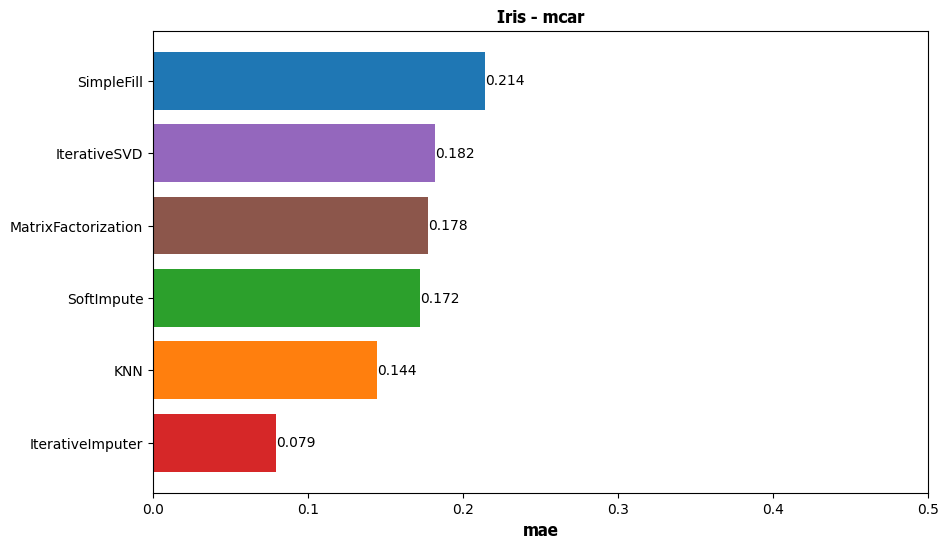

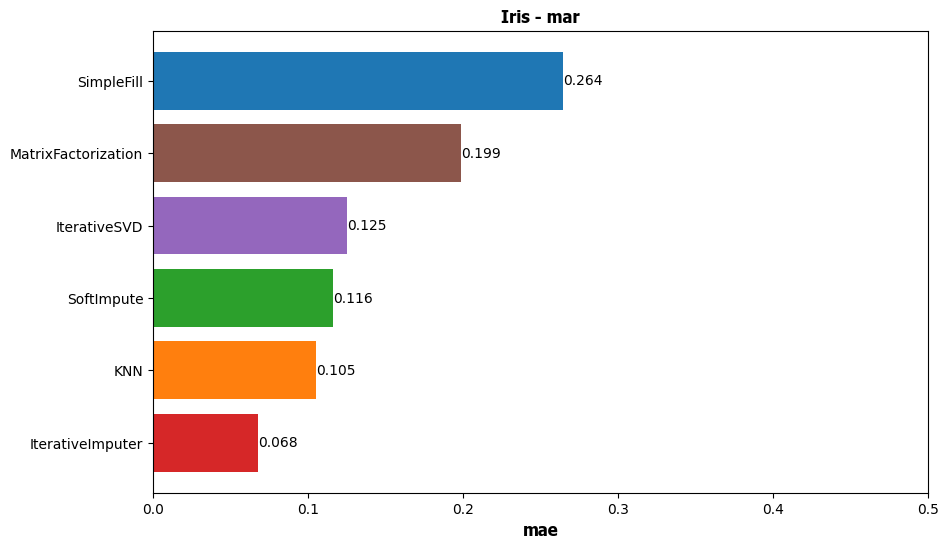

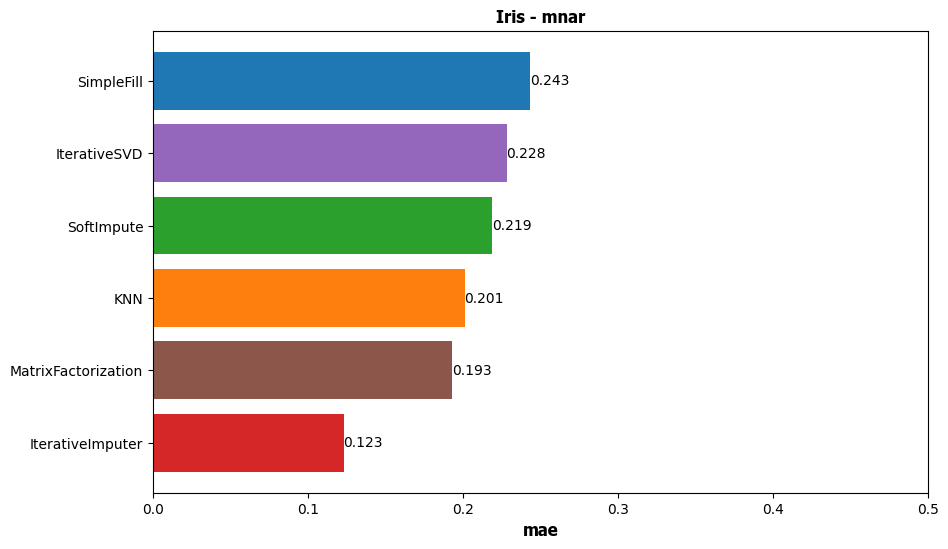

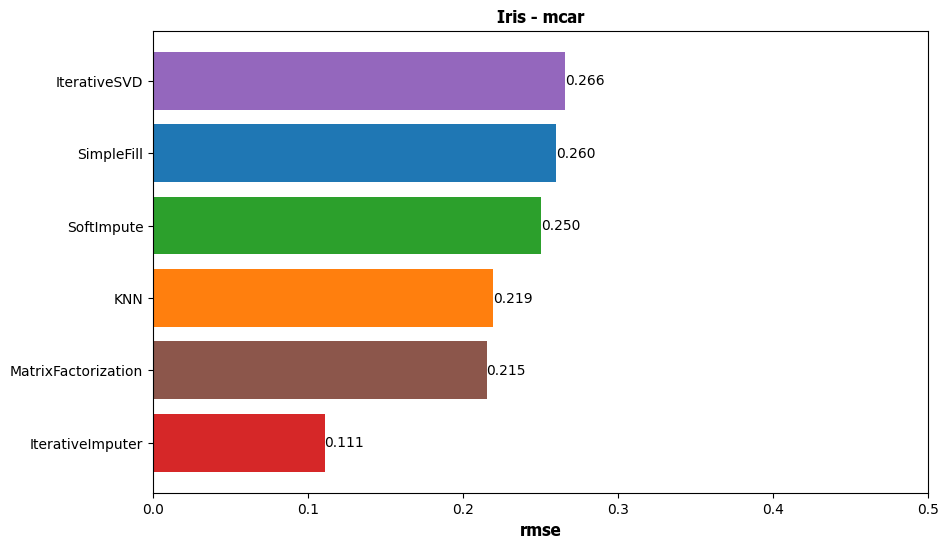

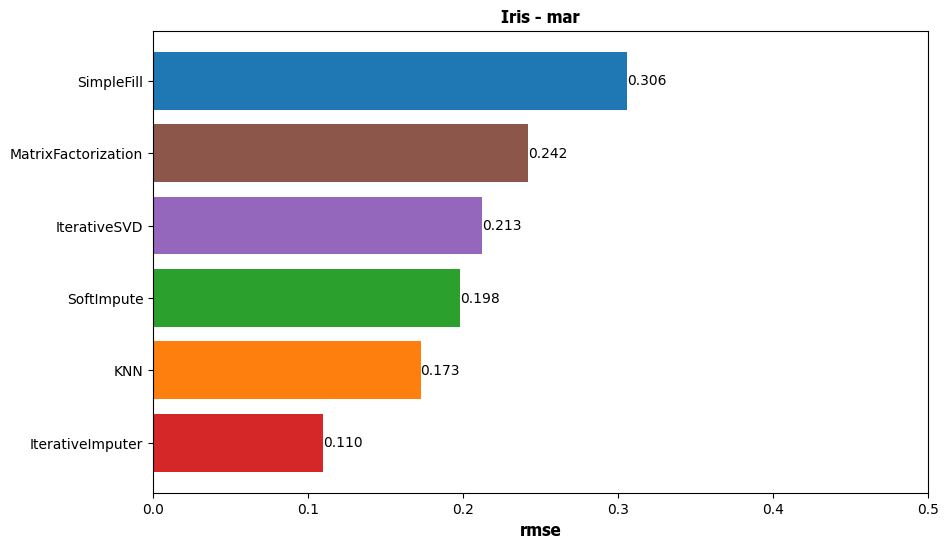

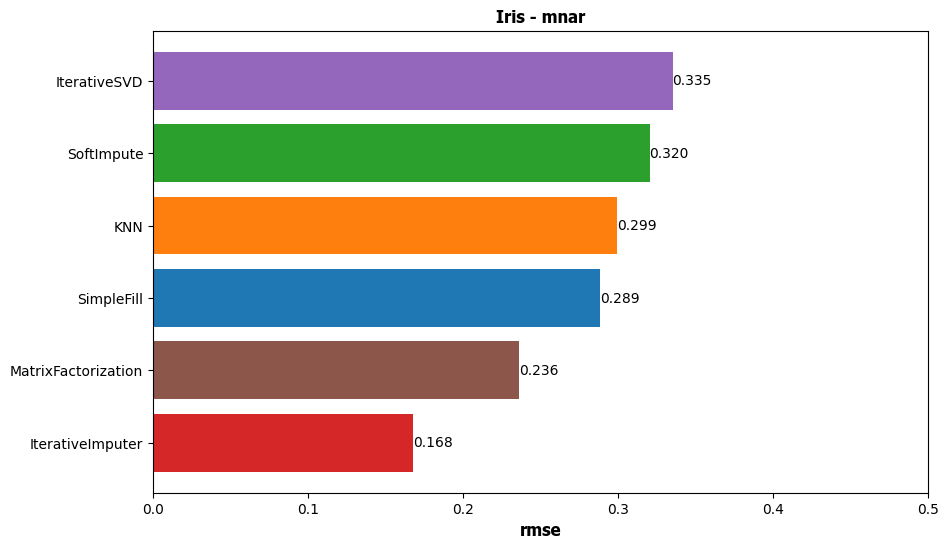

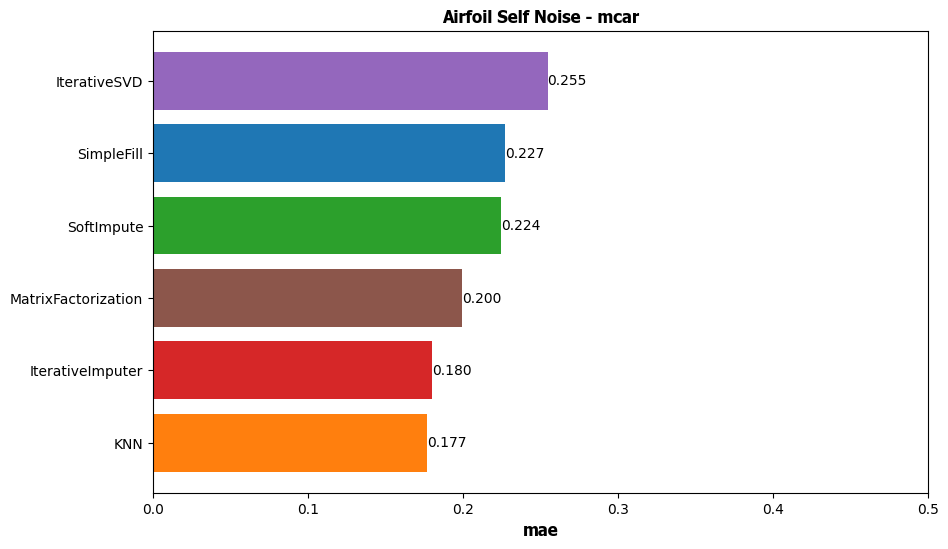

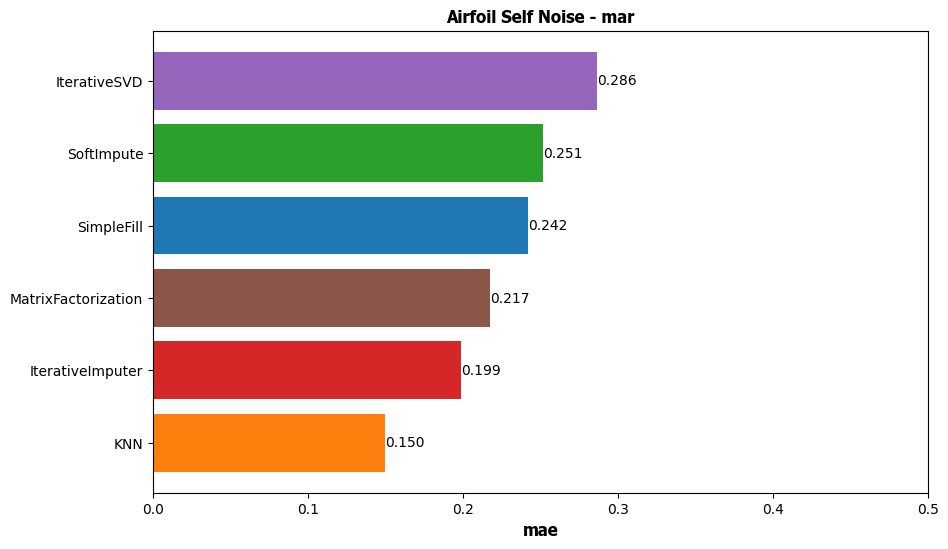

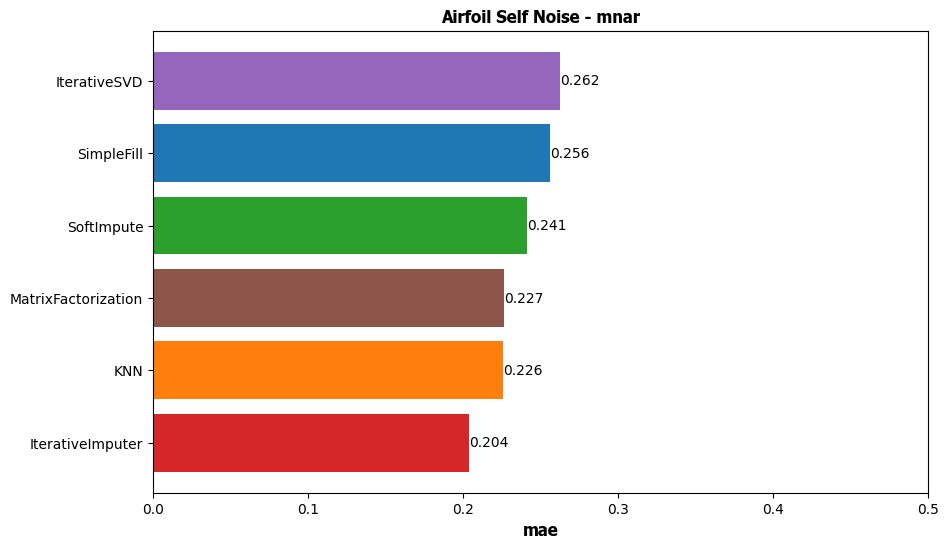

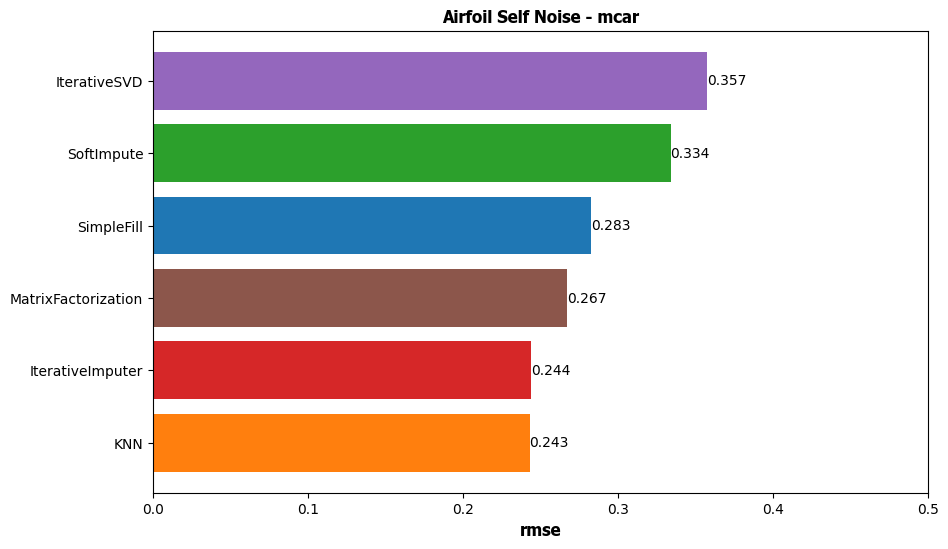

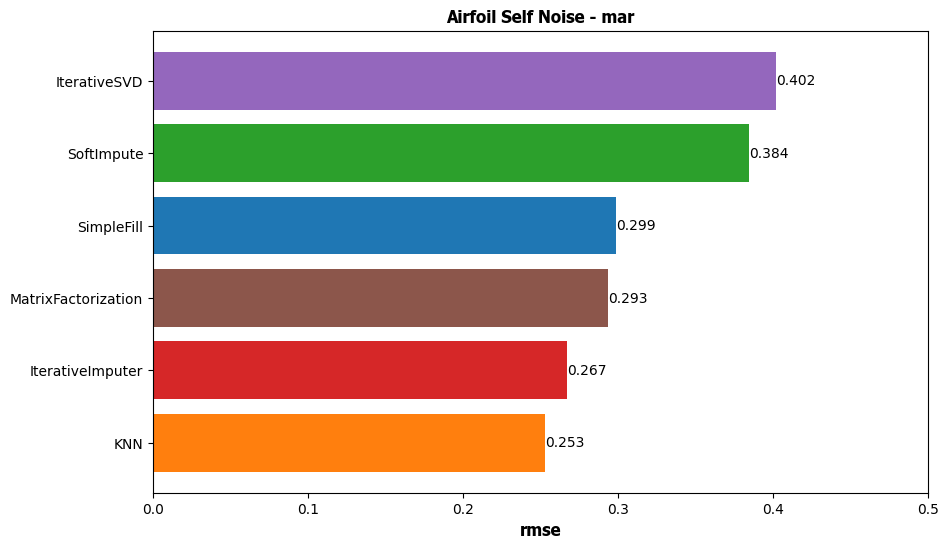

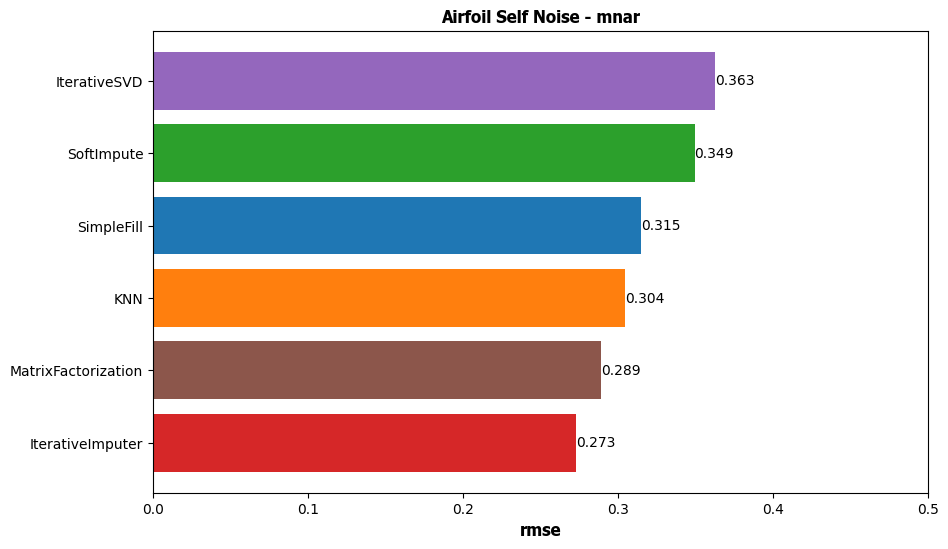

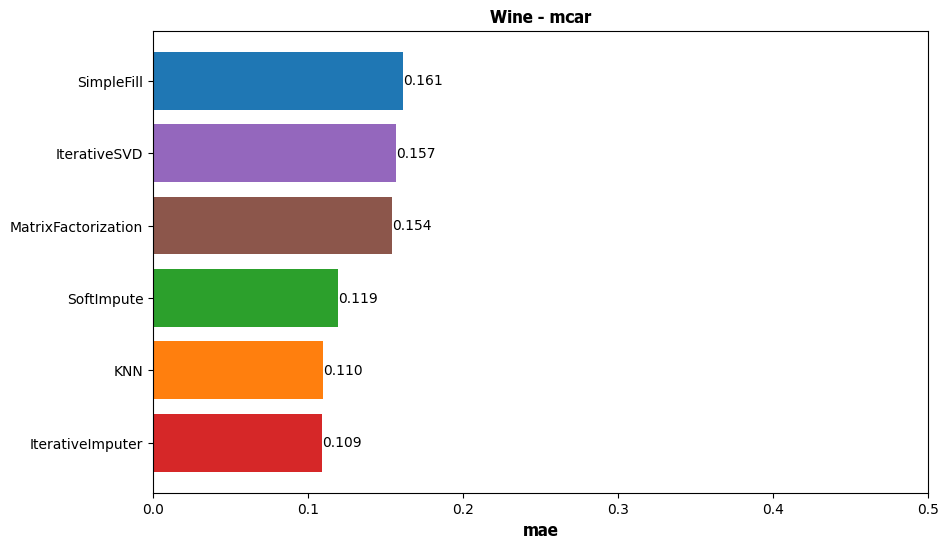

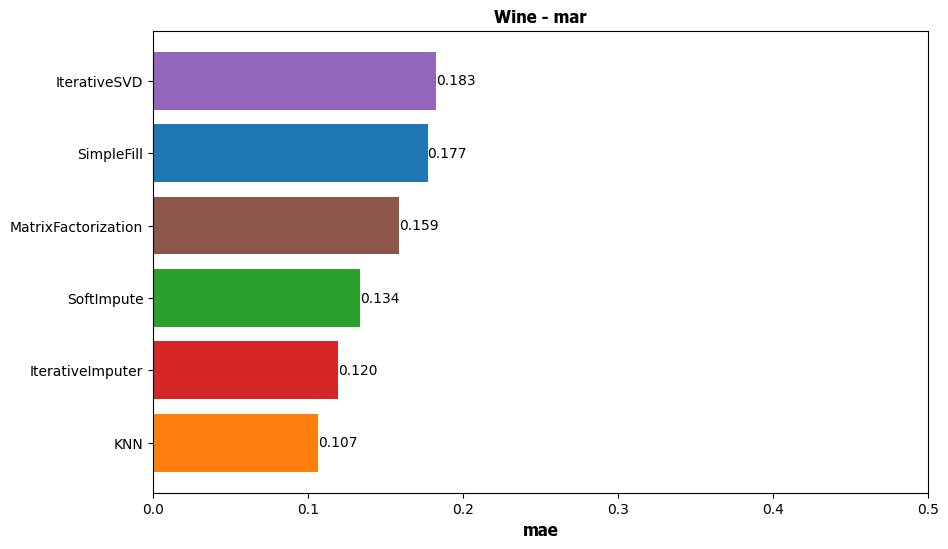

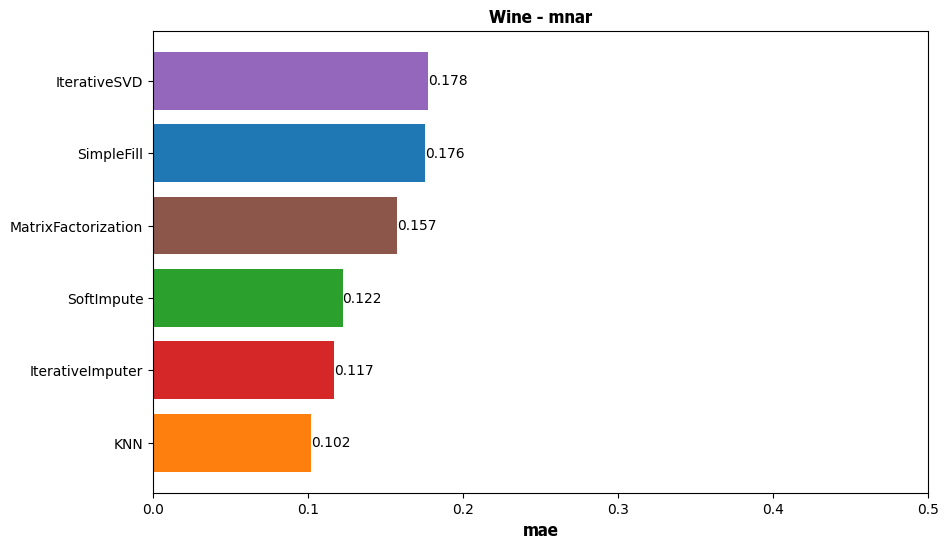

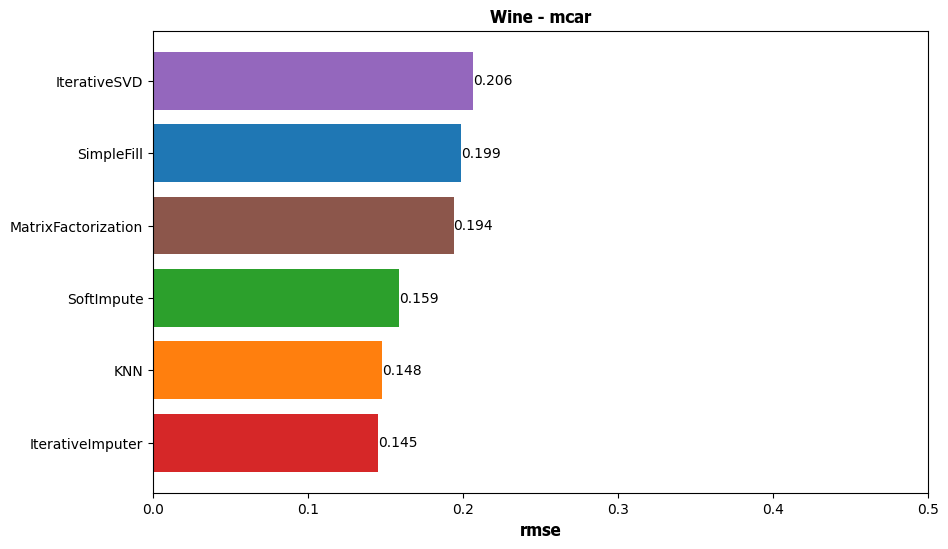

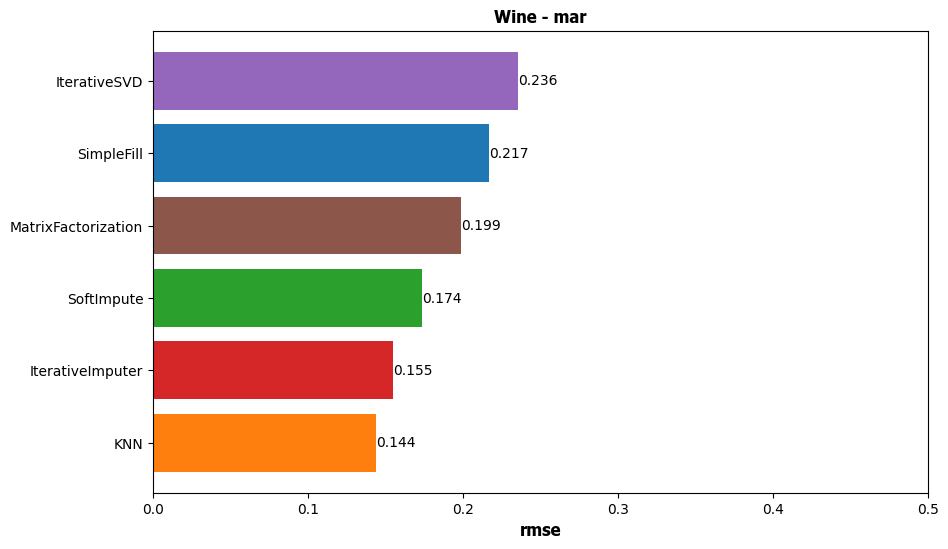

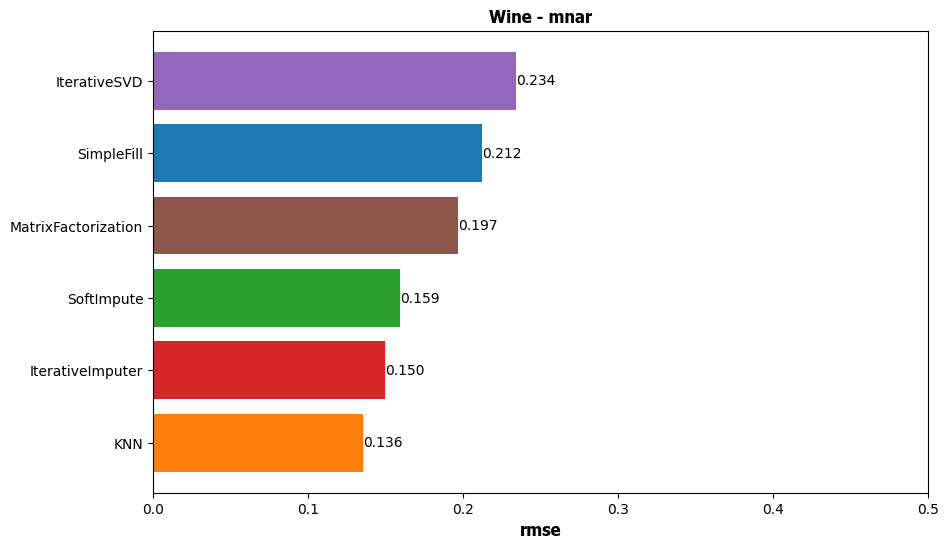

In [51]:
for dataset_name in results_mv_type:
    generate_mv_type_bar_plots(results_mv_type, dataset_name, 'mae')
    generate_mv_type_bar_plots(results_mv_type, dataset_name, 'rmse')

#### 2.2.2 Combined Datasets

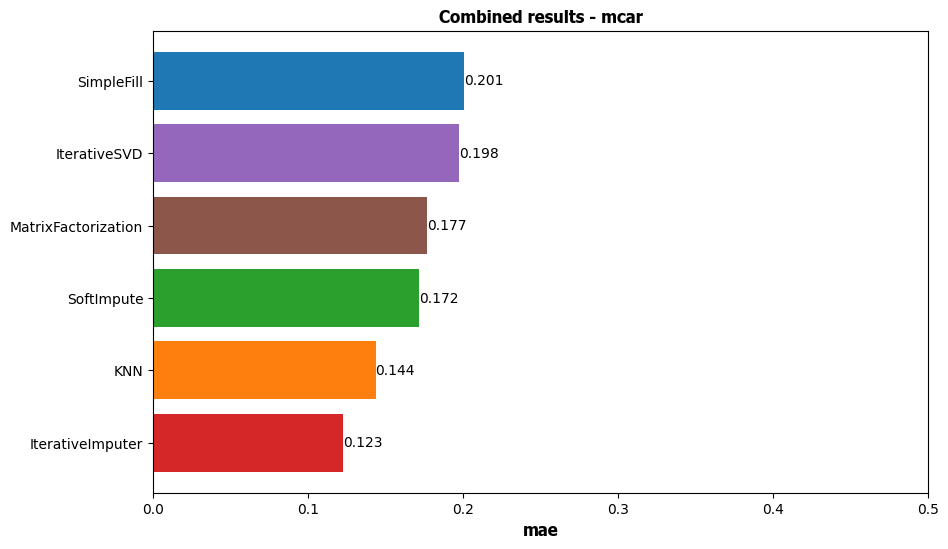

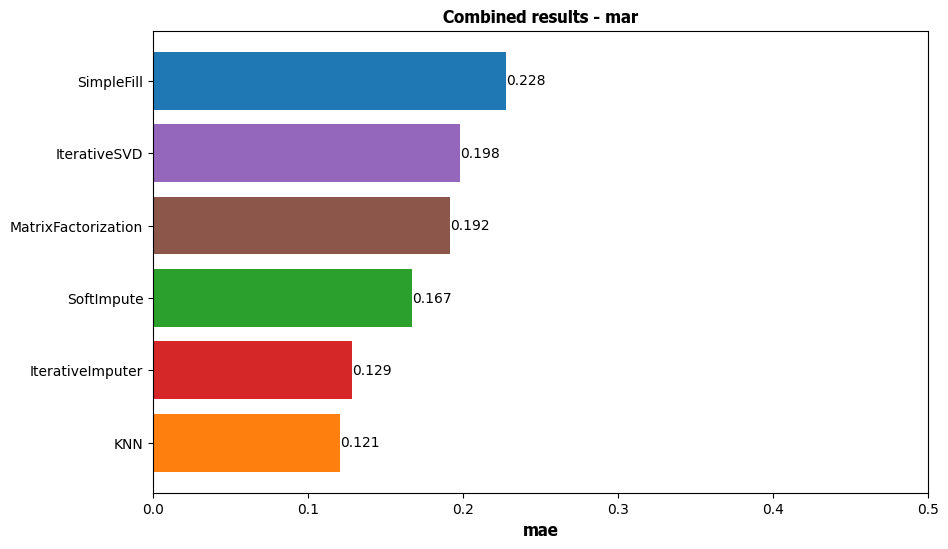

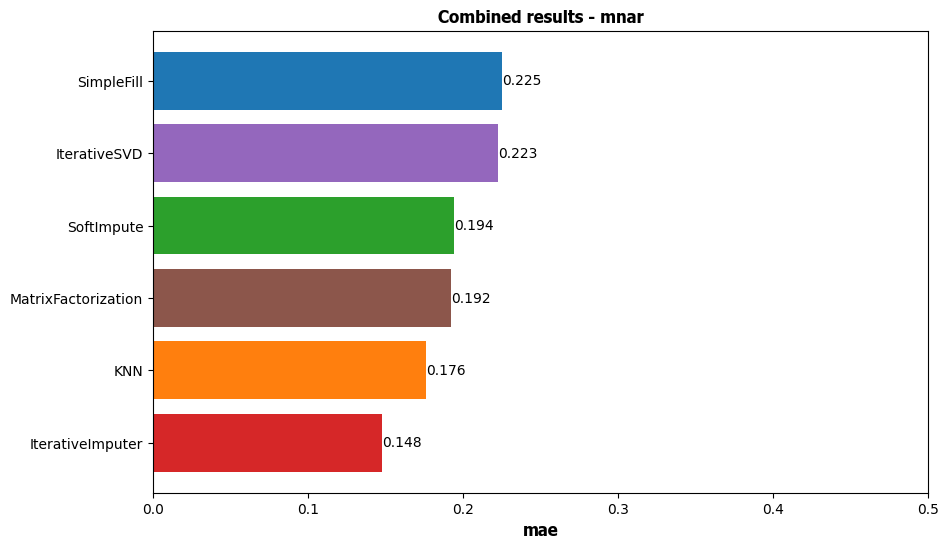

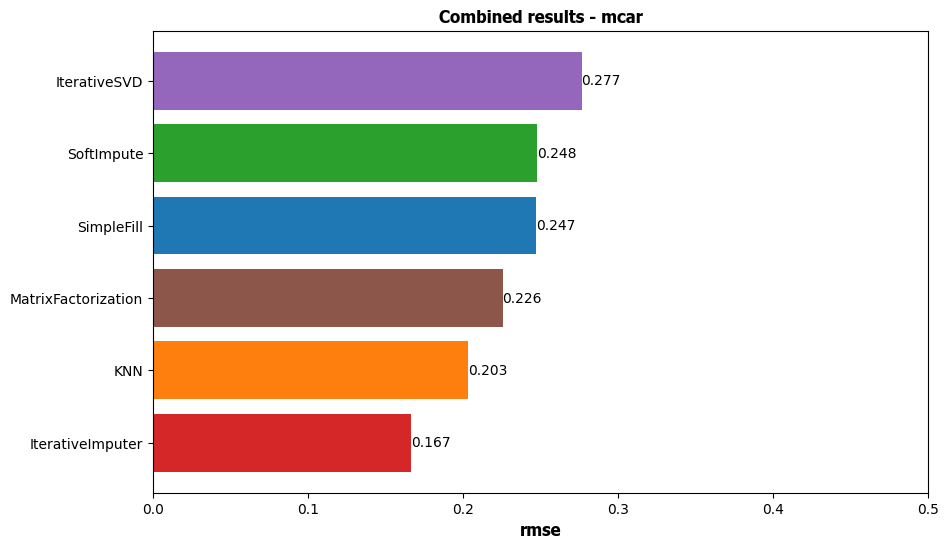

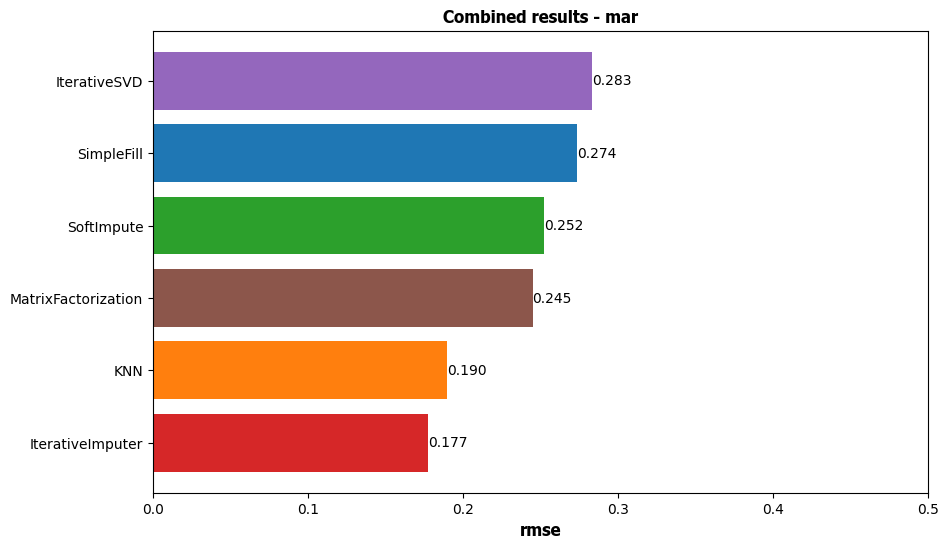

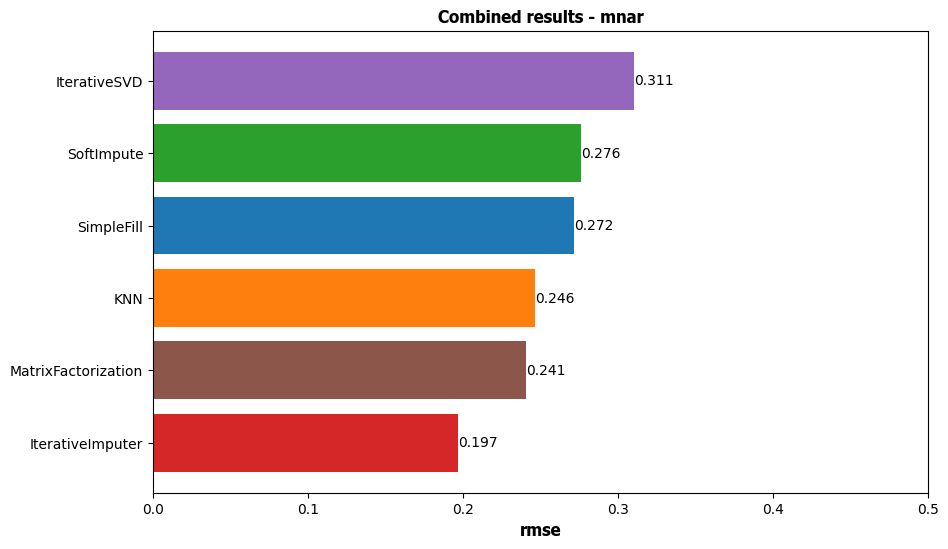

In [52]:
generate_mv_type_combined_bar_plots(results_mv_type, 'mae')
generate_mv_type_combined_bar_plots(results_mv_type, 'rmse')

## 3. Impute for Missing Value Proportions

### 3.1 Imputation

In [12]:
results_mv_proportions = {}

# Iterate data sets
for data_name, data_path in data_path_pairs:

    results_per_dataset = {}

    # Load Data
    data = pd.read_csv(data_path, header=None)

    # Scale Data
    data.columns = data.columns.astype(str)
    X_true = scaler.fit_transform(data)

    for percentage in mv_proportions:
        
        results_per_percentage = {}

        # Get Missing Data Mask
        # MCAR with varying proportions of missing values
        mv_mask = MCAR_mask(X_true, percentage)

        # Insert missing values
        X_dropped = X_true.copy()
        X_dropped[mv_mask] = np.nan

        # Iterate through Imputers
        for imputer_name, imputer in imputer_pairs:

            if isinstance(imputer, IterativeSVD):
                # Rank of IterativeSVD imputer must not be less than the x shape of the dataset
                # 10 is the default rank
                imputer.rank = min(10, data.shape[1] - 1)

            # Impute
            X_pred = imputer.fit_transform(X_dropped)
            
            results_per_percentage[imputer_name] = GetResultDictionaryForImputation(X_true, X_pred, mv_mask)
        
        results_per_dataset[percentage] = results_per_percentage
    
    results_mv_proportions[data_name] = results_per_dataset

c:\Users\brand\miniconda3\envs\fancyImputeEnvironment\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\brand\miniconda3\envs\fancyImputeEnvironment\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\brand\miniconda3\envs\fancyImputeEnvironment\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\brand\miniconda3\envs\fancyImputeEnvironment\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\brand\miniconda3\envs\fancyImputeEnvironment\Lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### 3.2 Results
#### 3.2.1 Individual Datasets

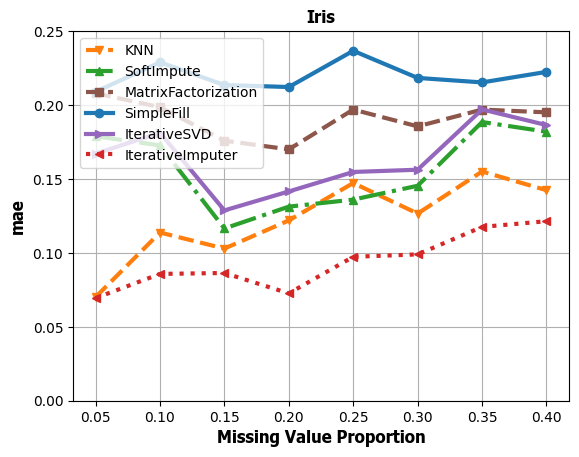

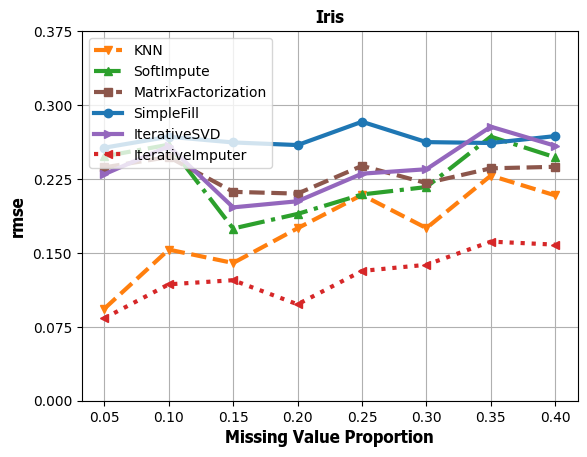

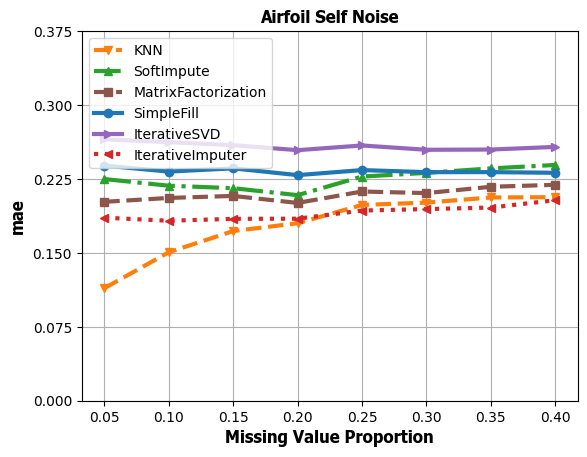

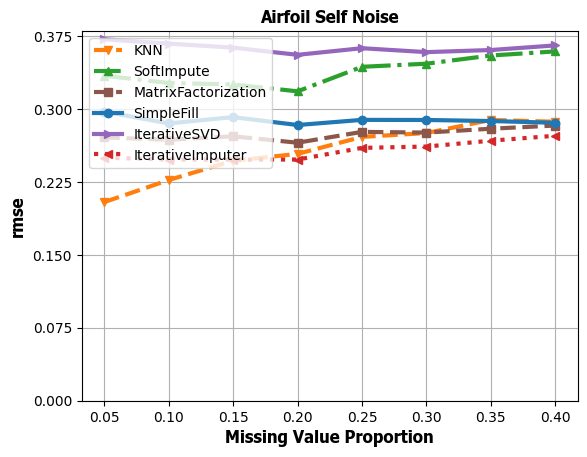

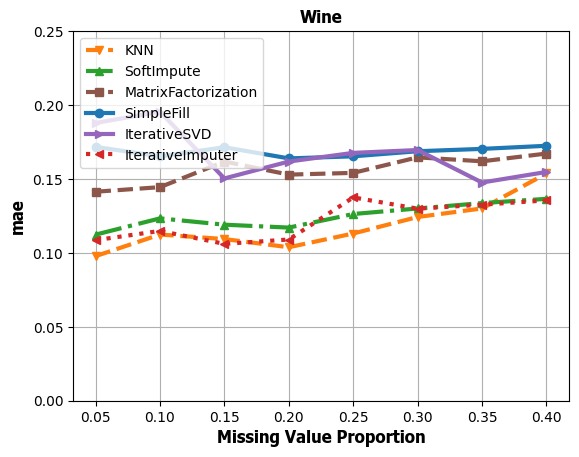

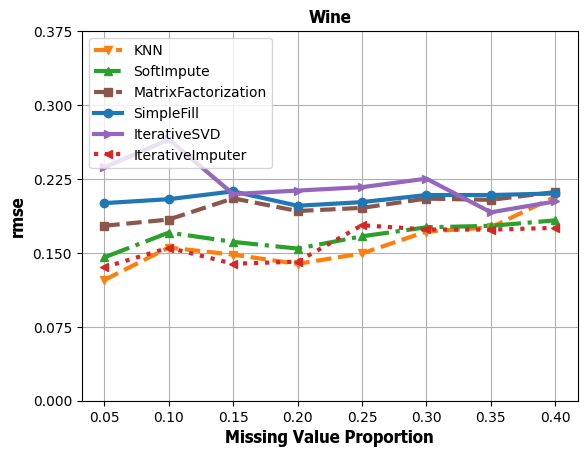

In [53]:
for dataset_name in results_mv_proportions:
    generate_mv_proportion_bar_plots(results_mv_proportions, dataset_name, 'mae')
    generate_mv_proportion_bar_plots(results_mv_proportions, dataset_name, 'rmse')

#### 3.2.2 Combined Datasets

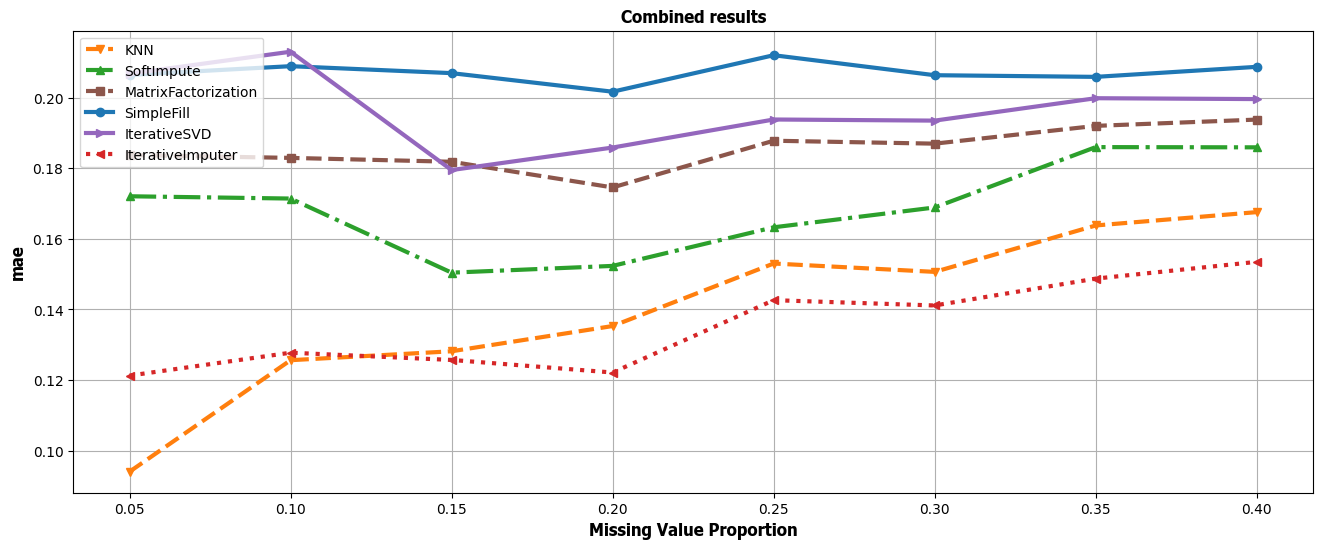

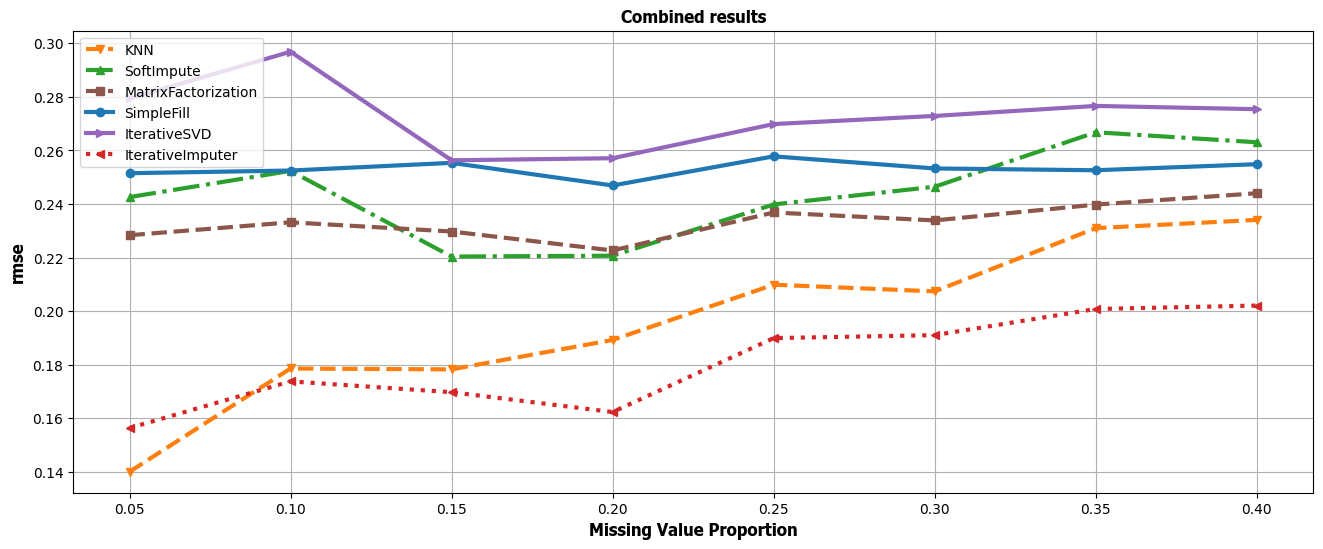

In [14]:
generate_mv_proportion_combined_bar_plots(results_mv_proportions, 'mae', (16,6))
generate_mv_proportion_combined_bar_plots(results_mv_proportions, 'rmse', (16,6))